# **1. Importation des librairies**

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler


In [ ]:
#Added Library
from matplotlib import pyplot as plt
import shutil           #Suppression dossier
from torchvision.transforms import v2
from PIL import Image
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms.functional import to_pil_image, to_tensor
from sklearn.model_selection import train_test_split
from collections import Counter

# **2. Fonctions**

# **2. Importation du modèle**

## 2.1. Resnet50

In [ ]:
fireModel = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Number of features in the last layer
num_ftrs = fireModel.fc.in_features

# Define the new fully connected layer sequence
new_fc = nn.Sequential(
    nn.Linear(num_ftrs, 64),    # New fully connected layer with 64 neurons
    nn.ReLU(inplace=True),                  # ReLU activation function
    nn.Dropout(0.3),            # Dropout layer with a probability of 30%
    nn.Linear(64, 3)            # Output layer with 3 neurons for 3 classes
)

# Replace the model's fully connected layer with the new sequence
fireModel.fc = new_fc

classifier = "ResNet50"


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 37.8MB/s]


##2.2. Resnet50 - Load model


In [ ]:
modelPath = 'FireResNet50-100PQ.pt'
fireModel = torch.load(modelPath)
classifier = "ResNet50"

#**3. Téléchargement des données d'entrainement**

##3.1. Données de d'entrainement

In [ ]:
bases_path_after="bases"
if os.path.exists(bases_path_after) == True:
    shutil.rmtree(bases_path_after) #Suppresion du dossier

os.makedirs(bases_path_after) #Création du dossier

class DownloadSwitch:
    def case(self, DbNumber):
      default= "Incorrect value"
      return (getattr(self, 'case_' + str(DbNumber)), lambda: default)
    def case_small(self): #Base de donnée: small test
      ! wget --no-check-certificate https://nextcloud.ig.umons.ac.be/s/QP7FoyttxJgS8Cj/download/small.zip
      !unzip small.zip -d 'bases'
      !rm small.zip
      return "small"
    def case_1(self): #Base de donnée: FIRE_DATABASE_1
      !wget --no-check-certificate https://nextcloud.ig.umons.ac.be/s/REWbK6K4XRtoeNw/download/FIRE_DATABASE_1.zip
      !unzip FIRE_DATABASE_1.zip -d 'bases'
      !rm FIRE_DATABASE_1.zip
      return "FIRE_DATABASE_1"
    def case_2(self): #Base de donnée: FIRE_DATABASE_2
       !wget --no-check-certificate https://nextcloud.ig.umons.ac.be/s/faKyDy7LCxfz9Xk/download/FIRE_DATABASE_2.zip
       !unzip FIRE_DATABASE_2.zip -d 'bases'
       !rm FIRE_DATABASE_2.zip
       return "FIRE_DATABASE_2"
    def case_3(self): #Base de donnée: FIRE_DATABASE_3
       !wget --no-check-certificate https://nextcloud.ig.umons.ac.be/s/KaqzczZsXfsnMER/download/FIRE_DATABASE_3.zip
       !unzip FIRE_DATABASE_3.zip -d 'bases'
       !rm FIRE_DATABASE_3.zip
       return "FIRE_DATABASE_3"
    def case_4(self): #Base de donnée: FIRE_DATABASE_Perso
       !wget --no-check-certificate http://millesaveurs.celeonet.fr/umons/defi01/FIRE_DATABASE_Perso.zip
       !unzip FIRE_DATABASE_Perso.zip -d 'bases'
       !rm FIRE_DATABASE_Perso.zip
       return "FIRE_DATABASE_Perso"

DlDatabase = DownloadSwitch()

if os.path.exists(bases_path_after) == True:
    DbDownloaded = DlDatabase.case_4()      #Sélection de la base de donnée

--2024-05-19 08:32:42--  http://millesaveurs.celeonet.fr/umons/defi01/FIRE_DATABASE_Perso.zip
Resolving millesaveurs.celeonet.fr (millesaveurs.celeonet.fr)... 95.128.72.24
Connecting to millesaveurs.celeonet.fr (millesaveurs.celeonet.fr)|95.128.72.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 425898023 (406M) [application/zip]
Saving to: ‘FIRE_DATABASE_Perso.zip’

FIRE_DATABASE_Perso 100%[===================>] 406.17M  7.94MB/s    in 56s     

2024-05-19 08:33:39 (7.20 MB/s) - ‘FIRE_DATABASE_Perso.zip’ saved [425898023/425898023]

Archive:  FIRE_DATABASE_Perso.zip
   creating: bases/FIRE_DATABASE_Perso/
   creating: bases/FIRE_DATABASE_Perso/fire/
  inflating: bases/FIRE_DATABASE_Perso/fire/00000001.jpg  
  inflating: bases/FIRE_DATABASE_Perso/fire/00000003.jpg  
  inflating: bases/FIRE_DATABASE_Perso/fire/00000004.jpg  
  inflating: bases/FIRE_DATABASE_Perso/fire/00000005.jpg  
 extracting: bases/FIRE_DATABASE_Perso/fire/00000006.jpg  
  inflating: bases/

##3.2. Données de tests

In [ ]:
test_path_after="test"
if os.path.exists(test_path_after) == True:
    shutil.rmtree(test_path_after) #Suppresion du dossier

os.makedirs(test_path_after) #Création du dossier

!wget https://nextcloud.ig.umons.ac.be/s/XqEMQtqQNPoG2cY/download/test.zip      # Test Dataset
!unzip test.zip -d test
!rm test.zip

--2024-05-19 08:33:47--  https://nextcloud.ig.umons.ac.be/s/XqEMQtqQNPoG2cY/download/test.zip
Resolving nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)... 193.190.209.220
Connecting to nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)|193.190.209.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57038454 (54M) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[===================>]  54.40M  11.6MB/s    in 4.9s    

2024-05-19 08:33:54 (11.1 MB/s) - ‘test.zip’ saved [57038454/57038454]

Archive:  test.zip
   creating: test/test/
   creating: test/test/fire/
  inflating: test/test/fire/F_1001.jpg  
  inflating: test/test/fire/F_2062.jpg  
  inflating: test/test/fire/F_2063.jpg  
  inflating: test/test/fire/F_2064.jpg  
  inflating: test/test/fire/F_2066.jpg  
  inflating: test/test/fire/F_2067.jpg  
  inflating: test/test/fire/F_2068.jpg  
  inflating: test/test/fire/F_2070.jpg  
  inflating: test/test/fire/F_2071.jpg  
  inflating: test/t

#**4. Paramètres d'entrainement et sélection du modèle pré-entrainé**

##4.1. Paramètres communs

In [ ]:
#Structure dossier - Permet de retravailler les images sans retélécharger le set initial
bases_path= "bases"
basesF_path="bases_Filtered"
basesOpti_path ="bases_Optim"

In [ ]:
device       = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # define the device to use (cuda:0 if the gpu is availble)
dataset_base  = bases_path
dataset_name='FIRE_DATABASE_Perso'
datasetPath = os.path.join(dataset_base + '/', dataset_name)                # define the path to the dataset (where a folder is a class)
test_datasetPath='test/test'
batchSize	 = 32                                                             # define the batch size
trainSplit   = 0.8                                                            # define the ratio of data to use for training
testSplit    = 0.0                                                            # define the ratio of data to use for testing
validSplit   = 0.2                                                            # the rest is used for validation
epochs		 = 20                                                            # define the number of epoch
criterion    = nn.CrossEntropyLoss()                                          # define the loss function
learnRate	 = 0.01                                                           # define the learning rate
#optimizer    = optim.Adam(fireModel.parameters(), lr=learnRate)                # define the optimizer
optimizer = optim.SGD(fireModel.parameters(), lr=learnRate, momentum=0.9)


AttributeError: 'collections.OrderedDict' object has no attribute 'parameters'

##4.2. Paramètres propre au modèle

In [ ]:
match classifier:                                                       # define the input size
      #Xception familly
      case 'Xception':
        imgSize = 299

      #VGG familly
      case 'VGG16':
        imgSize = 224

      case 'VGG19':
        imgSize = 224

      #ResNet familly
      case 'ResNet50':
        imgSize = 224

      case 'ResNet101':
        imgSize = 224

      case 'ResNet152':
        imgSize = 224

      case 'ResNet50V2':
        imgSize = 224

      case 'ResNet101V2':
        imgSize = 224

      case 'ResNet152V2':
        imgSize = 224

      #Inception familly
      case 'InceptionV3':
        imgSize = 299

      case 'InceptionResNetV2':
        imgSize = 299

      #MobileNet familly
      case 'MobileNet':
        imgSize = 224

      case 'MobileNetV2':
        imgSize = 224

      #DenseNet familly
      case 'DenseNet121':
        imgSize = 224

      case 'DenseNet169':
        imgSize = 224

      case 'DenseNet201':
        imgSize = 224

      #NasNet
      case 'NASNetLarge':
        imgSize = 331

      case 'NASNetMobile':
        imgSize = 224

      case _:
        print("unknown classifier : " + classifier)

#**5. Création Dataset**

##5.1. Normalisation Dataset

In [ ]:
# Transforms for base dataset
transform = transforms.Compose([
    transforms.RandomResizedCrop(imgSize),  # Resize the picture
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
# Preparing target (label) transformations (composition of transforms)
target_transform = transforms.Compose([
    lambda label: torch.nn.functional.one_hot(torch.tensor(label), num_classes=3).float()
])

##5.2. Training Dataset

In [ ]:
# Create the dataset based on the path and apply the transformations defined above
dataset = datasets.ImageFolder(
    datasetPath,
    transform=transform,
    target_transform=target_transform
)

# Extract labels for stratification
labels = [dataset.targets[i] for i in range(len(dataset))]

# Compute the number of pictures that will be used for train, validation
trainlen = int(trainSplit * len(dataset))
validlen = len(dataset) - trainlen

# Split indices into train and temp (valid + test) sets
train_indices, valid_indices = train_test_split(
    np.arange(len(dataset)), stratify=labels, train_size=trainlen, test_size=validlen, shuffle=True, random_state=42)

# Count the number of images per class in each split
train_labels = [labels[i] for i in train_indices]
valid_labels = [labels[i] for i in valid_indices]

train_counts = Counter(train_labels)
valid_counts = Counter(valid_labels)

print(f'Train class distribution: {train_counts}')
print(f'Validation class distribution: {valid_counts}')

# Define the augmentation transformations
augmentation_transform = transforms.Compose([
    transforms.RandomRotation(degrees=(1, 50)),
    transforms.RandomAffine(degrees=0, scale=(0.1, 0.2), shear=(0.1, 0.2), translate=(0.1, 0.2)),
])
class AugmentedDataset(Dataset):
    def __init__(self, dataset, transform=None, augmentation_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.augmentation_transform = augmentation_transform
    def __len__(self):
        # Return twice the length to account for original and augmented images
        return 2 * len(self.dataset)
    def __getitem__(self, idx):
        # Determine whether to return the original or augmented image
        original_idx = idx // 2
        img, target = self.dataset[original_idx]
        if idx % 2 == 0:
            # Return the original image (transformed)
            return img, target
        else:
            # Return the augmented image
            if self.augmentation_transform:
                augmented_img = to_pil_image(img)  # Convert to PIL image for augmentation
                augmented_img = self.augmentation_transform(augmented_img)
                augmented_img = to_tensor(augmented_img)  # Convert back to tensor
                augmented_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(augmented_img)  # Re-normalize
                return augmented_img, target
            else:
                return img, target

# Create the augmented dataset
augmented_dataset = AugmentedDataset(dataset, transform=transform, augmentation_transform=augmentation_transform)

# Duplicate train indices for augmentation
train_indices = list(train_indices)
augmented_train_indices = []
for idx in train_indices:
    augmented_train_indices.append(2 * idx)
    augmented_train_indices.append(2 * idx + 1)

# Create a loader for each subset based on its sampler with a batch_size
trainloader = DataLoader(
    augmented_dataset,
    batch_size=batchSize,
    sampler=SubsetRandomSampler(augmented_train_indices)  # Use the SubsetRandomSampler with the correct indices
)
valloader = DataLoader(
    dataset,
    batch_size=batchSize,
    sampler=SubsetRandomSampler(valid_indices)
)

# Count the number of images per class after augmentation in training set
augmented_train_labels = [labels[idx // 2] for idx in augmented_train_indices]
augmented_train_counts = Counter(augmented_train_labels)

print(f'Train length: {trainlen}')
print(f'Validation length: {validlen}')
print(f'Augmented train class distribution: {augmented_train_counts}')


Train class distribution: Counter({0: 522, 1: 344, 2: 328})
Validation class distribution: Counter({0: 131, 1: 86, 2: 82})
Train length: 1194
Validation length: 299
Augmented train class distribution: Counter({0: 1044, 1: 688, 2: 656})


##5.3. Test Dataset


In [ ]:
test_dataset=datasets.ImageFolder(
    test_datasetPath,
    transform=transform,
    target_transform=target_transform
)

# Compute the number of pictures that will be used for test
testlen = len(test_dataset)

# Extract labels for stratification
test_labels = [test_dataset.targets[i] for i in range(len(test_dataset))]
test_counts = Counter(test_labels)

print(f'Test class distribution: {test_counts}')

# Create a loader for each subset based on its sampler with a batch_size
testloader = DataLoader(
    test_dataset,
    batch_size=1,
)
print(f'Test length: {testlen}')

Test class distribution: Counter({0: 100, 1: 100, 2: 100})
Test length: 300


#**6. Entrainement du modèle**

In [ ]:
train_loss_list = []
train_results_list = []
val_loss_list = []
val_results_list = []

In [ ]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.25)
fireModel = fireModel.to(device) # Move the model to the GPU or CPU if no GPU are available

# Train the model for each epoch
for epoch in range(epochs):
	# Training
	fireModel.train(True)			# set the model in training mode
	totalAccuracy = 0.0				# manually compute accuracy, set 0% as inital accuracy
	totalLoss = 0.0						# manually compute the loss, set 0% as inital loss
	counter = 0								# count number of data during an epoch (to divide accuracy and loss)
	for (i, data) in enumerate(trainloader): 									# for each $i$th batch of data in the trainset
		inputs, labels	= data																	# put the picture tensor into $inputs$ and labels into $labels$
		inputs, labels	= inputs.to(device), labels.to(device)	# move inputs and labels to the device (GPU/CPU)
		optimizer.zero_grad()																		# reset the gradient
		outputs					= fireModel(inputs)											# Forward pass (predict) the ouputs
		loss						= criterion(outputs, labels)						# Compute the loss
		loss.backward()																					# Compute updates of parameters
		optimizer.step()																				# Update the parameters
		accuracy				= outputs.argmax(dim=1) == labels.argmax(dim=1)	# Compute the batch accuracy (when outpus match the labels)
		totalAccuracy  += accuracy.int().sum()										# add the batch accuracy to the total accuracy
		totalLoss 	   += loss.item()															# do the same with the loss
		counter				 += len(inputs)															# increase the counter

	# Print loss and accuracy
	loss_value= totalLoss / counter  #List Train_Loss; Train_Val
	result_value = 100 * totalAccuracy / counter
	train_loss_list.append(loss_value)
	train_results_list.append(result_value.item())
	print(f'train [{epoch + 1}] loss: {totalLoss / counter:.3f} accuracy: {result_value:.3f}%')
	# Validate
	fireModel.train(False)	# Disable training mode (useful when dropout)
	with torch.no_grad():		# Disable autograd (speedup)
		totalAccuracy	= 0.0
		totalLoss		= 0.0
		counter					= 0
		for (i, data) in enumerate(valloader):
			inputs, labels	= data
			inputs, labels	= inputs.to(device), labels.to(device)
			outputs					= fireModel(inputs)
			loss						= criterion(outputs, labels)
			accuracy				= outputs.argmax(dim=1) == labels.argmax(dim=1)
			totalAccuracy += accuracy.int().sum()
			totalLoss	 += loss.item()
			counter				 += len(inputs)

		# Print loss and accuracy
		loss_value= totalLoss / counter  #List Train_Loss; Train_Val
		result_value = 100 * totalAccuracy / counter
		val_loss_list.append(loss_value)
		val_results_list.append(result_value.item())

		print(f'validation [{epoch + 1}] loss: {totalLoss / counter:.3f} accuracy: {result_value:.3f}%')
		torch.save(fireModel, f'FireResNet50-{epoch + 1:d}.pt')

		# Step the scheduler
		scheduler.step()

torch.save(fireModel, 'FireResNet50.pt')


train [1] loss: 0.023 accuracy: 63.358%
validation [1] loss: 0.013 accuracy: 84.615%
train [2] loss: 0.021 accuracy: 68.467%
validation [2] loss: 0.010 accuracy: 88.294%
train [3] loss: 0.019 accuracy: 71.357%
validation [3] loss: 0.010 accuracy: 89.632%
train [4] loss: 0.020 accuracy: 71.985%
validation [4] loss: 0.010 accuracy: 89.967%
train [5] loss: 0.020 accuracy: 71.608%
validation [5] loss: 0.009 accuracy: 92.977%
train [6] loss: 0.019 accuracy: 72.655%
validation [6] loss: 0.008 accuracy: 91.304%
train [7] loss: 0.019 accuracy: 71.901%
validation [7] loss: 0.010 accuracy: 91.973%
train [8] loss: 0.019 accuracy: 73.032%
validation [8] loss: 0.008 accuracy: 92.642%
train [9] loss: 0.019 accuracy: 71.943%
validation [9] loss: 0.007 accuracy: 91.639%
train [10] loss: 0.019 accuracy: 72.446%
validation [10] loss: 0.010 accuracy: 91.639%
train [11] loss: 0.017 accuracy: 74.288%
validation [11] loss: 0.010 accuracy: 90.635%
train [12] loss: 0.017 accuracy: 75.335%
validation [12] loss

#**7. Afficher des courbes d'entrainement/validation**

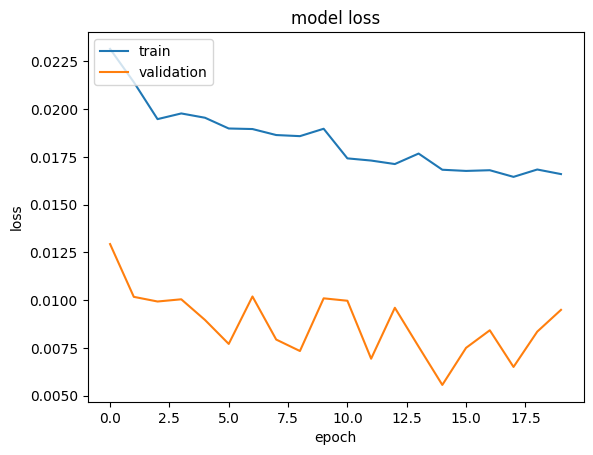

In [ ]:
5#  loss
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

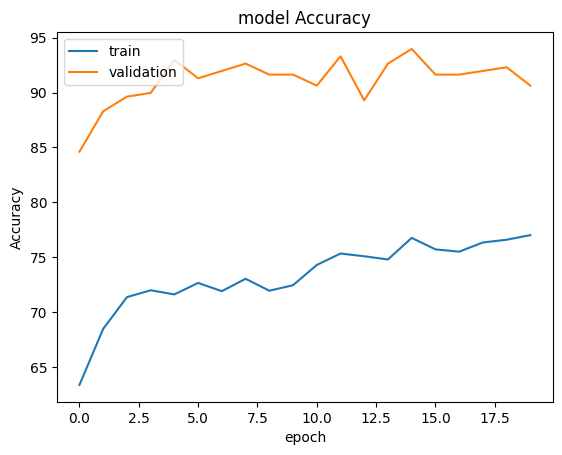

In [ ]:
#  Accuracy
plt.plot(train_results_list)
plt.plot(val_results_list)
plt.title('model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# **8. Evaluer le modèle avec ce jeu de données de test avec la fonction evaluate()**

In [31]:
fireModel = torch.load('results/FireResNet50-100PK.pt')
fireModel.train(False)
with torch.no_grad():
  totalAccuracy	= 0.0
  totalLoss		= 0.0
  counter					= 0
  for (i, data) in enumerate(testloader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    # forward
    outputs = fireModel(inputs)
    loss = criterion(outputs, labels)
    accuracy	= outputs.argmax(dim=1) == labels.argmax(dim=1)
    totalAccuracy += accuracy.int().sum()
    totalLoss += loss.item()
    counter += len(inputs)
  print(f'Test loss: {totalLoss / counter:.3f} accuracy: {100 * totalAccuracy / counter:.3f}%')

Test loss: 0.863 accuracy: 80.667%


In [37]:
fireModel = torch.load('results/FireResNet50-100PK.pt')
fireModel.train(False)
fireModel.eval()

all_preds = []
all_labels = []
wrong_preds = []

with torch.no_grad():
  totalAccuracy = 0.0
  totalLoss   = 0.0
  counter         = 0
  for (i, data) in enumerate(testloader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    # forward
    outputs = fireModel(inputs)
    loss = criterion(outputs, labels)
    accuracy  = outputs.argmax(dim=1) == labels.argmax(dim=1)
    totalAccuracy += accuracy.int().sum()
    totalLoss += loss.item()
    counter += len(inputs)

    all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
    all_labels.extend(labels.argmax(dim=1).cpu().numpy())

  print(f'Test loss: {totalLoss / counter:.3f} accuracy: {100 * totalAccuracy / counter:.3f}%')

Test loss: 0.715 accuracy: 84.333%


In [ ]:
print(len(all_preds))

300


#**9. Matrice de confusion**

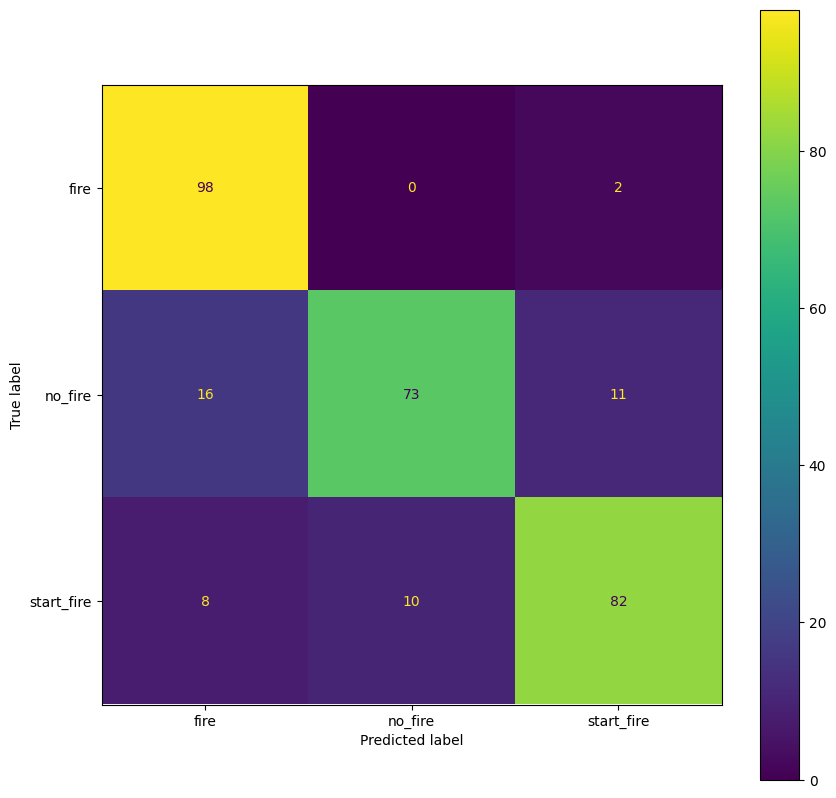

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)

# Afficher la matrice de confusion
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)
plt.show()

#**10. CompressionScript**


##10.1. Prunning


###10.1.1. Librairy import

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.1/281.1 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.7 MB/s eta 0:00:00


In [ ]:
!pip install torch_pruning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 1.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyli

###10.1.2. Pruning compression

In [ ]:
# pruner retrain and log everything in wandb
# Imports
import wandb
import torch.nn.functional as F
import torch
import torch_pruning as tp
import os
import copy
import random
import numpy as np
import torch
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm
from functools import partial
assert torch.cuda.is_available()


# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



### CONFIG ###

# model
modelPath='models/FireResNet50-100.pt'
#modelPath='FireResNet50-100.pt'
model = torch.load(modelPath).to(device)


# training parameters
batch_size = 32
epochs = 100
lr = 0.01
random_seed = 42

# pruning parameters
method = "group_norm" # choices "random", "l1", "lamp", "slim", "group_norm", "group_sl"
speed_up = 2 # speed up ratio based on MACs
compression_ratio = 2 # compression ratio based on model size
global_pruning = True # if True: global pruning else: local
iterative_steps = 400 # pruning steps
max_sparsity = 1 # max sparsity

num_classes = 3 # to avoid pruning last layer


# Fixer le seed pour la reproductibilité
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Here you can create your dataloader because after pruning, you should retrain the model: récupérer code depuis code entraînement
# dataloader = ...

# Evaluation loop
@torch.no_grad()
def evaluate(
    model: nn.Module,
    dataloader: DataLoader,
    verbose=True,
) -> float:
    model.eval()

    num_samples = 0
    num_correct = 0
    loss = 0

    for inputs, targets in tqdm(dataloader, desc="eval", leave=False, disable=not verbose):
        # Move the data from CPU to GPU
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Inference
        outputs = model(inputs)
        # Calculate loss
        loss += F.cross_entropy(outputs, targets, reduction="sum")
        # Convert logits to class indices
        outputs = outputs.argmax(dim=1)
        # Update metrics
        num_samples += targets.size(0)
        num_correct += (outputs == targets).sum()
    return (num_correct / num_samples * 100).item(), (loss / num_samples).item()

# training loop
def train(
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    epochs: int,
    lr: int,
    # for pruning
    weight_decay=5e-4,
    pruner=None,
    callbacks=None,
    save=None,
    save_only_state_dict=False,
) -> None:

    optimizer = torch.optim.SGD(model.parameters(
    ), lr=lr, momentum=0.9, weight_decay=weight_decay if pruner is None else 0)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,80,100], gamma=0.1)
    criterion = nn.CrossEntropyLoss()
    best_acc = -1
    best_checkpoint = dict()


    for epoch in range(epochs):
        model.train()
        for inputs, targets in tqdm(train_loader, leave=False):
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Reset the gradients (from the last iteration)
            optimizer.zero_grad()

            # Forward inference
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward propagation
            loss.backward()

            # Pruner regularize for sparsity learning
            if pruner is not None:
                pruner.regularize(model)

            # Update optimizer
            optimizer.step()

            if callbacks is not None:
                for callback in callbacks:
                    callback()

        acc, val_loss = evaluate(model, test_loader)
        print(
            f'Epoch {epoch + 1}/{epochs} | Val acc: {acc:.2f} | Val loss: {val_loss:.4f} | LR: {optimizer.param_groups[0]["lr"]:.6f}')

        if best_acc < acc:
            best_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
            best_acc = acc
        # Update LR scheduler
        scheduler.step()
    model.load_state_dict(best_checkpoint['state_dict'])
    if save:
        # on veut sauvegarder le meilleur modèle
        path = os.path.join(os.getcwd(), "results", save)
        os.makedirs(os.path.dirname(path), exist_ok=True)
        if save_only_state_dict:
            torch.save(model.state_dict(), path)
        else:
            torch.save(model, path)
    print(f'Best val acc: {best_acc:.2f}')



# Pruner
# définir le nbre de classses => évite de pruner la dernière couche
def get_pruner(model, example_input):
    sparsity_learning = False
    if method == "random":
        imp = tp.importance.RandomImportance()
        pruner_entry = partial(tp.pruner.MagnitudePruner, global_pruning=global_pruning)
    elif method == "l1":
        imp = tp.importance.MagnitudeImportance(p=1)
        pruner_entry = partial(tp.pruner.MagnitudePruner, global_pruning=global_pruning)
    elif method == "lamp":
        imp = tp.importance.LAMPImportance(p=2)
        pruner_entry = partial(tp.pruner.BNScalePruner, global_pruning=global_pruning)
    elif method == "slim":
        sparsity_learning = True
        imp = tp.importance.BNScaleImportance()
        pruner_entry = partial(tp.pruner.BNScalePruner, reg=1e-5, global_pruning=global_pruning)
    elif method == "group_norm":
        imp = tp.importance.GroupNormImportance(p=2)
        pruner_entry = partial(tp.pruner.GroupNormPruner, global_pruning=global_pruning)
    elif method == "group_sl":
        sparsity_learning = True
        imp = tp.importance.GroupNormImportance(p=2)
        pruner_entry = partial(tp.pruner.GroupNormPruner, reg=1e-5, global_pruning=global_pruning)
    else:
        raise NotImplementedError

    unwrapped_parameters = []
    ignored_layers = []
    ch_sparsity_dict = {}
    # ignore output layers
    for m in model.modules():
        if isinstance(m, torch.nn.Linear) and m.out_features == num_classes:
            ignored_layers.append(m)
        elif isinstance(m, torch.nn.modules.conv._ConvNd) and m.out_channels == num_classes:
            ignored_layers.append(m)


    # Here we fix iterative_steps=200 to prune the model progressively with small steps
    # until the required speed up is achieved.
    pruner = pruner_entry(
        model,
        example_input,
        importance=imp,
        iterative_steps=iterative_steps,
        ch_sparsity=1,
        ch_sparsity_dict=ch_sparsity_dict,
        #max_ch_sparsity=max_sparsity,
        ignored_layers=ignored_layers,
        unwrapped_parameters=unwrapped_parameters,
    )
    return pruner

# pruning jusqu'à atteindre le speed up voulu
def progressive_pruning_speedup(pruner, model, speed_up, example_inputs):
    model.eval()
    base_ops, _ = tp.utils.count_ops_and_params(
        model, example_inputs=example_inputs)
    current_speed_up = 1
    while current_speed_up < speed_up:
        pruner.step(interactive=False)
        pruned_ops, _ = tp.utils.count_ops_and_params(
            model, example_inputs=example_inputs)
        current_speed_up = float(base_ops) / pruned_ops
        # print(current_speed_up)
        if pruner.current_step == pruner.iterative_steps:
            break
    return current_speed_up


# pruning jusqu'à atteindre le ratio de compression voulu
def progressive_pruning_compression_ratio(pruner, model, compression_ratio, example_inputs):
    # compression ratio défini par taille initiale / taille finale
    model.eval()
    _, base_params = tp.utils.count_ops_and_params(
        model, example_inputs=example_inputs)
    current_compression_ratio = 1
    while current_compression_ratio < compression_ratio:
        pruner.step(interactive=False)
        _, pruned_params = tp.utils.count_ops_and_params(
            model, example_inputs=example_inputs)
        current_compression_ratio = float(base_params) / pruned_params
        if pruner.current_step == pruner.iterative_steps:
            break
        # print(current_compression_ratio)
    return current_compression_ratio



def main():
    # Avant pruning
    example_input = torch.rand(1, 3, 224, 224).to(device)
    start_macs, start_params = tp.utils.count_ops_and_params(model, example_input)
    print('----- Avant pruning -----')
    print(f'Nombre de MACs = {start_macs/1e6:.3f} M')
    print(f'Nombre de paramètres = {start_params/1e6:.3f} M')
    print('')

    pruner = get_pruner(model, example_input)
    print(f'Pruning method = {method}')

    # pruning using compression ratio as objective
    # progressive_pruning_compression_ratio(pruner, model, compression_ratio, example_input)

    # pruning using speed up ratio as objective (Number of MACs)
    progressive_pruning_speedup(pruner, model, speed_up, example_input)
    pruned_macs, pruned_params = tp.utils.count_ops_and_params(model, example_input)
    print('----- Après pruning -----')
    print(f'Nombre de MACs = {pruned_macs/1e6:.3f} M')
    print(f'Nombre de paramètres = {pruned_params/1e6:.3f} M')
    print('')

    # Results
    print('----- Results before fine tuning -----')
    print(f'Params: {start_params/1e6:.2f} M => {pruned_params/1e6:.2f} M')
    print(f'MACs: {start_macs/1e6:.2f} M => {pruned_macs/1e6:.2f} M')
    print('')


if __name__ == "__main__":
    main()


----- Avant pruning -----
Nombre de MACs = 4120.007 M
Nombre de paramètres = 23.639 M

Pruning method = group_norm


/usr/local/lib/python3.10/dist-packages/torch_pruning/pruner/algorithms/metapruner.py:87: UserWarning: ch_sparsity is deprecated in v1.3.0. Please use pruning_ratio.
  warnings.warn("ch_sparsity is deprecated in v1.3.0. Please use pruning_ratio.")
/usr/local/lib/python3.10/dist-packages/torch_pruning/pruner/algorithms/metapruner.py:90: UserWarning: ch_sparsity_dict is deprecated in v1.3.0. Please use pruning_ratio_dict instead.
  warnings.warn("ch_sparsity_dict is deprecated in v1.3.0. Please use pruning_ratio_dict instead.")


----- Après pruning -----
Nombre de MACs = 2050.742 M
Nombre de paramètres = 17.736 M

----- Results before fine tuning -----
Params: 23.64 M => 17.74 M
MACs: 4120.01 M => 2050.74 M



In [ ]:
# Calculer le nombre total de paramètres
total_model_params = sum(p.numel() for p in model.parameters())

# Calculer le nombre de paramètres entraînables
trainable_model_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Nombre total de paramètres: {total_model_params}")
print(f"Nombre de paramètres entraînables: {trainable_model_params}")

Nombre total de paramètres: 17735971
Nombre de paramètres entraînables: 17735971


In [ ]:
torch.save(model, f'ModelPruned.pt')

##10.2. Quantization

###10.2.1. Library installation

In [35]:
!pip install tensorrt

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for tensorrt: filename=tensorrt-10.0.1-py2.py3-none-any.whl size=16331 sha256=f8e3790892ee52f2a43ffe67885d939c1b833360ddd445162007cf18ab4a0b79
  Stored in directory: /root/.cache/pip/wheels/43/0e/35/f5de9a100ae769ece311b8f653e493f7e49bbcc25dcdc92e27
  Created wheel for tensorrt-cu12: filename=tensorrt_cu12-10.0.1-py2.py3-none-any.whl size=17551 sha256=2c347c58ed0c58eb0fb722250bad3beecaa0023f33f044b7f6ae711eaac5a343
  Stored in directory: /root/.cache/pip/wheels/3d/65/7d/75f1bf55d7e57b0c82cb037d1d39d53851946315222eaf4c76
Successfully built tensorrt tensorrt-cu12


In [39]:
!git clone https://github.com/NVIDIA-AI-IOT/torch2trt
!cd /content/torch2trt
!python /content/torch2trt/setup.py install

Cloning into 'torch2trt'...
remote: Enumerating objects: 4452, done.
remote: Counting objects: 100% (4452/4452), done.
remote: Compressing objects: 100% (1848/1848), done.
remote: Total 4452 (delta 2593), reused 4320 (delta 2547), pack-reused 0
Receiving objects: 100% (4452/4452), 7.75 MiB | 13.25 MiB/s, done.
Resolving deltas: 100% (2593/2593), done.
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packag

###10.2.2. Quantization compression

In [41]:
import torch
import torch
import numpy as np
import torch
from tqdm.auto import tqdm
assert torch.cuda.is_available()
from torch2trt import torch2trt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

modelPath='results/FireResNet50-100PK.pt'
model = torch.load(modelPath).to(device)

example_input = torch.randn(1, 3, 224, 224).cuda()


model_trt = torch2trt(model,[example_input], fp16_mode=True)

torch.save(model_trt.state_dict(), 'results_PKQ.pt')

ModuleNotFoundError: No module named 'torch2trt.flattener'

In [ ]:
# Calculer le nombre total de paramètres
total_model_params = sum(p.numel() for p in model.parameters())

# Calculer le nombre de paramètres entraînables
trainable_model_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Nombre total de paramètres: {total_model_params}")
print(f"Nombre de paramètres entraînables: {trainable_model_params}")

##10.3. Knowledge distillation

In [ ]:
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import copy
import os
import torch.nn.functional as F
import random
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Evaluation loop
@torch.no_grad()
def evaluate(
    model: nn.Module,
    dataloader: DataLoader,
    verbose=True,
) -> float:
    model.eval()

    num_samples = 0
    num_correct = 0
    loss = 0

    for inputs, targets in tqdm(dataloader, desc="eval", leave=False, disable=not verbose):
        # Move the data from CPU to GPU
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Inference
        outputs = model(inputs)
        # Calculate loss
        loss += F.cross_entropy(outputs, targets, reduction="sum")
        # Convert logits to class indices
        outputs = outputs.argmax(dim=1)
        # Update metrics
        num_samples += targets.size(0)
        num_correct += (outputs == targets).sum()
    return (num_correct / num_samples * 100).item(), (loss / num_samples).item()

# training loop
def train_kd(
    model_student: nn.Module,
    model_teacher: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    epochs: int,
    lr: int,
    weight_decay=5e-4,
    callbacks=None,
    save=None,
    save_only_state_dict=False,
) -> None:

    optimizer = torch.optim.SGD(model_student.parameters(
    ), lr=lr, momentum=0.9, weight_decay=weight_decay)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,80], gamma=0.1)
    criterion = nn.CrossEntropyLoss()
    best_acc = -1
    best_checkpoint = dict()


    for epoch in range(epochs):
        model_student.train()
        model_teacher.train()
        for inputs, targets in tqdm(train_loader, leave=False):
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Reset the gradients (from the last iteration)
            optimizer.zero_grad()

            # Forward inference
            out_student = model_student(inputs)
            out_teacher = model_teacher(inputs)


            # kd loss
            kd_T = 4
            predict_student = F.log_softmax(out_student / kd_T, dim=1)
            predict_teacher = F.softmax(out_teacher / kd_T, dim=1)
            alpha = 0.9
            loss = nn.KLDivLoss()(predict_student, predict_teacher) * (alpha * kd_T * kd_T) + criterion(out_student, targets) * (1-alpha)

            loss.backward()


            # Update optimizer
            optimizer.step()

            if callbacks is not None:
                for callback in callbacks:
                    callback()

        acc, val_loss = evaluate(model_student, test_loader)
        print(
            f'Epoch {epoch + 1}/{epochs} | Val acc: {acc:.2f} | Val loss: {val_loss:.4f} | LR: {optimizer.param_groups[0]["lr"]:.6f}')

        if best_acc < acc:
            best_checkpoint['state_dict'] = copy.deepcopy(model_student.state_dict())
            best_acc = acc
        # Update LR scheduler
        scheduler.step()
    model_student.load_state_dict(best_checkpoint['state_dict'])
    if save:
        # on veut sauvegarder le meilleur modèle
        path = os.path.join(os.getcwd(), "results", save)
        os.makedirs(os.path.dirname(path), exist_ok=True)
        if save_only_state_dict:
            torch.save(model_student.state_dict(), path)
        else:
            torch.save(model_student, path)
    print(f'Best val acc: {best_acc:.2f}')

# Fixer le seed pour la reproductibilité
import numpy as np
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


# Here you should defined your dataloader
train_dataloader = trainloader
test_dataloader = valloader

student_model = 'FireResNet50-100PK.pt' # torch.load(model_path)
teacher_model = 'models/FireResNet50-100.pt' # torch.load(model_path)


# train student model
print('train student model')
train_kd(student_model, teacher_model, train_dataloader, test_dataloader, epochs=100, lr=0.001, save="kdtest.pt")


train student model


AttributeError: 'str' object has no attribute 'parameters'

#**11. Modèle Vérification**

In [ ]:
# Calculer le nombre total de paramètres
total_model_params = sum(p.numel() for p in fireModel.parameters())

# Calculer le nombre de paramètres entraînables
trainable_model_params = sum(p.numel() for p in fireModel.parameters() if p.requires_grad)

print(f"Nombre total de paramètres: {total_model_params}")
print(f"Nombre de paramètres entraînables: {trainable_model_params}")

Nombre total de paramètres: 23639363
Nombre de paramètres entraînables: 23639363
